##### <font color=#A0A0A0>
##### ════════════════════════════════════════════════════════
#####     📊 **PREDICTION OF HOME PRICES**
##### ════════════════════════════════════════════════════════ </font>

#### 🎯 Project Objetive
Make price predictions of homes using the supervised resgression techniques to help buyers, sellers and real state agents to make more informed decisions.

In [52]:
#Import of used pakages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV,LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor, plot_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import statsmodels.api as sm
import warnings
import shap
import re

##### Feactures description of the dataset https://jse.amstat.org/v19n3/decock/DataDocumentation.txt

The above link conteins the description of the dataset including the categories of the ordinal and Nominal which are good data to find realationship with the SalePrice feature. 

In [2]:
#Data loading
data = pd.read_csv('../data/AmesHousing.csv')
data.shape

(2930, 82)

In [58]:
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
col_names = data.columns.tolist()

In [4]:
# Reading the data description provided by the dataset creator
try:
    with open('../data/DataDocumentation.txt', 'r', encoding='latin-1') as file:
        content = file.read()
except FileNotFoundError:
    print('Error')


In [5]:
# Now read each line and look for the variable name, type and the description with the regex code
# Then split then to make a dict and later a DataFrame
features_description = []
pattern = re.compile(r'^\s*(.+?)\s*\((.*?)\):\s*(.*)$') # regex code to match the info
options_list = []
for line in content.strip().split('\n'):
    line = line.strip()
    if not line:
        continue
    # "Fence (Ordinal): Fence quality" line of interest example
    match = pattern.match(line)
    if match:
        variable = match.group(1).strip()
        type_var = match.group(2).strip()
        description = match.group(3).strip()
        
        features_description.append({
            'Variable': variable,
            'Type Variable': type_var,
            'Description': description,
        })
        
df_description = pd.DataFrame(features_description)

#### <font color=#A0A0A0>📈 **Exploratory Data Analysis**</font>

Let's see if the data has outliers or null values

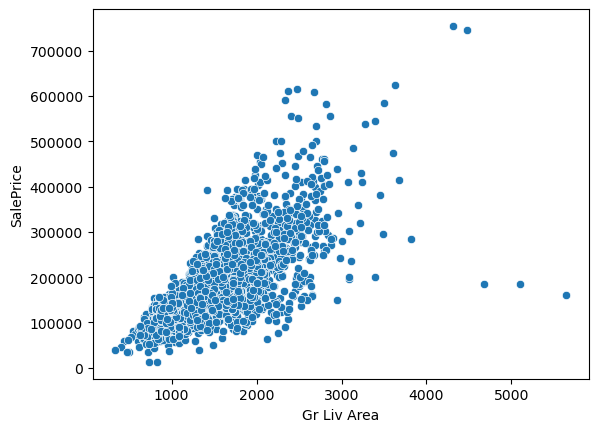

In [6]:
#The authors advice to check for aoutliers in the Gr Live Area feature
sns.scatterplot(data=data, x='Gr Liv Area', y='SalePrice')
plt.show()

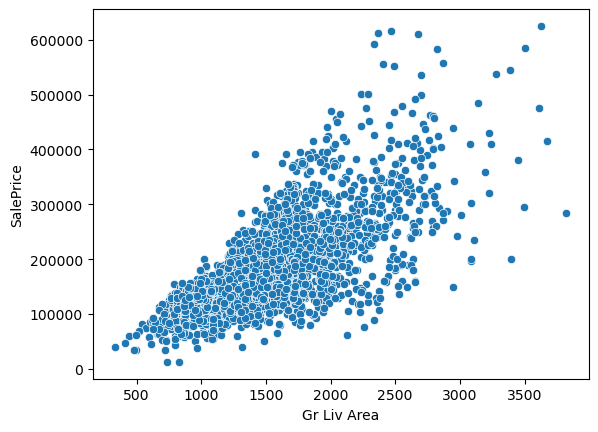

In [7]:
# The authors advice eliminate the rows with Gr Liv Area more than 4000 ft2. Which are considerated as outliers
df = data[data['Gr Liv Area']<4000]
sns.scatterplot(data=df, x='Gr Liv Area', y='SalePrice')
plt.show()

In [8]:
# The identifiers columns 'Oder' and 'PID' AmesHousing.csv don't give important information, it'll be go to drop them
drop_columns = ['Order', 'PID']

In [9]:
df_1 = df.drop(columns=drop_columns)

In [10]:
# Now it's time to separate the two classes of variables (continuos and categorical) to discard
numeric_cols = df_1.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_1.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['SalePrice']]

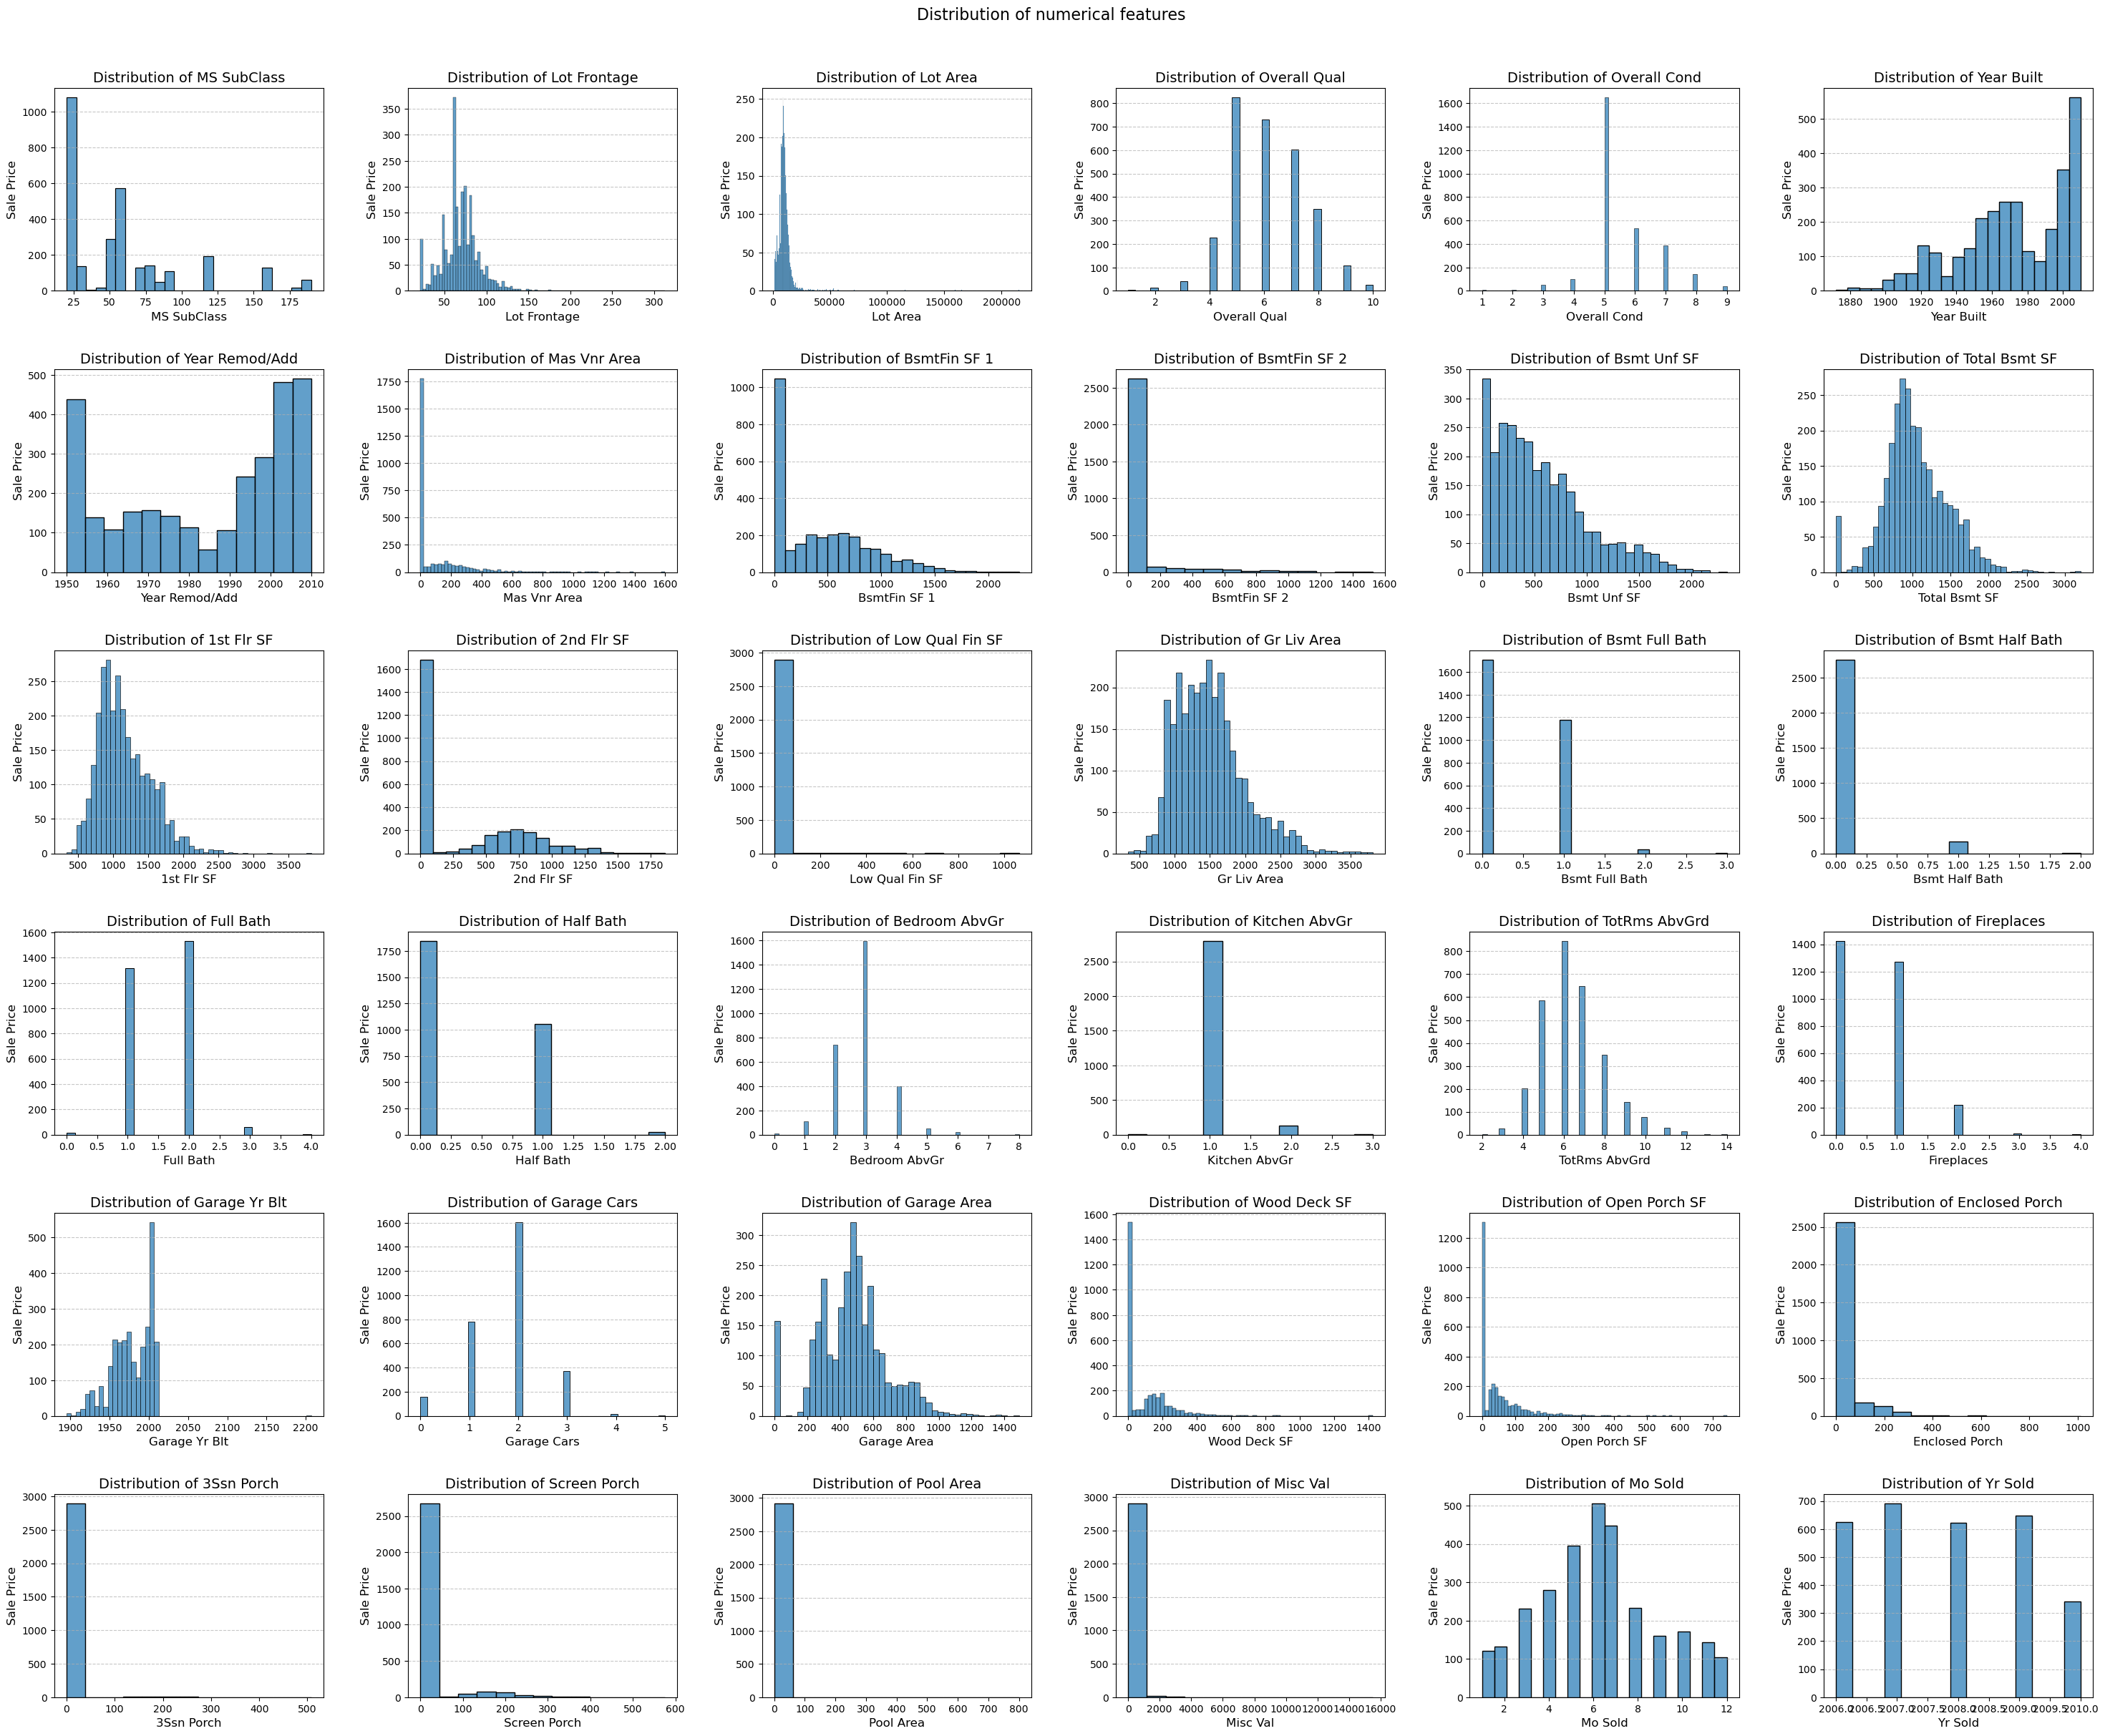

In [11]:
# Displaying all the numeric features of the data
n_cols = 6
n_rows = (len(numeric_cols)+n_cols-1) // n_cols
plt.figure(figsize=(n_cols*5, n_rows*4))

for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i+1)
    
    sns.histplot(x=df[col], alpha=0.7)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Sale Price', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
plt.tight_layout(pad=3.0)
plt.suptitle('Distribution of numerical features', fontsize=16, y=1.02)
plt.show()

Almost all the features have a normal distribution but there's three features with clear outliers (Lot Frontage, Lot Area and Garage Yr Blt). There is also features which have too many 0 values, and don't give too much information to the model (Low Variance).

#### <font color=#A0A0A0>**🧹 Preprocessing and Feature Selection**</font>

In [12]:
# With the objetive to take just extreme outliers the multiplication factor of the IQR will be set to 3
fea_outliers = ['Lot Frontage', 'Lot Area']
for i in fea_outliers:
    Q1 = df_1[i].quantile(0.25)
    Q3 = df_1[i].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 3 * IQR
    df_1.loc[df_1[i] > upper_bound, i] = upper_bound


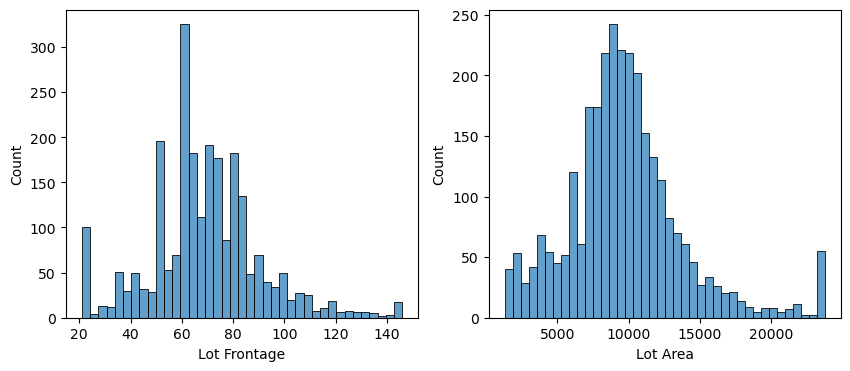

In [13]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(x=df_1['Lot Frontage'], alpha=0.7)
plt.subplot(1,2,2)
sns.histplot(x=df_1['Lot Area'], alpha=0.7)
plt.show()

In [14]:
#Identification of features with most of the 60% of missing values
def null_features_identification(df):
    columnas = df.columns    
    drop_columns = []
    for i in columnas:
        if len(df[df[i].isna()])/(len(df)) > 0.6:
            drop_columns.append(i)
    return drop_columns

null_columns = null_features_identification(df)
print(null_columns)

['Alley', 'Mas Vnr Type', 'Pool QC', 'Fence', 'Misc Feature']


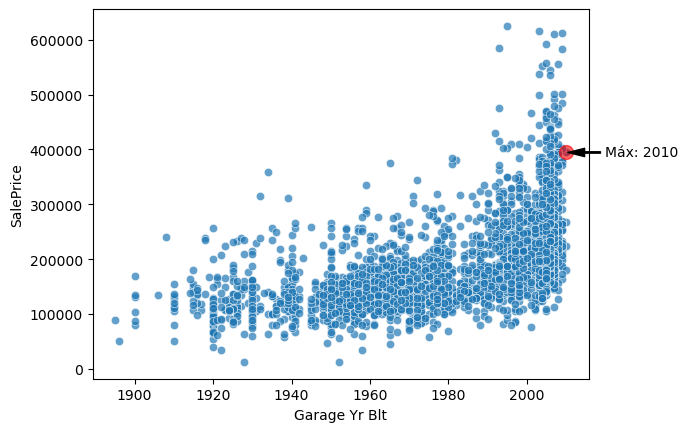

In [15]:
# Discarding atypical values in the feature 'Garage Yr Blt'
df_1 = df_1[df_1['Garage Yr Blt'] < 2025]
max_Garage_Yr_Blt = df_1.loc[df_1['Garage Yr Blt'].idxmax()]
x_max = max_Garage_Yr_Blt['Garage Yr Blt']
y_at_x_max = max_Garage_Yr_Blt['SalePrice']

sns.scatterplot(data=df_1, x='Garage Yr Blt', y='SalePrice', alpha=0.7)
plt.plot(max_Garage_Yr_Blt['Garage Yr Blt'], max_Garage_Yr_Blt['SalePrice'], 'ro', markersize=10, alpha=0.6)
plt.annotate(f'Máx: {int(x_max)}',
            xy=(x_max, y_at_x_max),
            xytext=(x_max + 10, y_at_x_max), # Ajusta la posición del texto
            ha='left', va='center',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6))
plt.show()

In [16]:
# To reduce the number of variables and don't waste resorces, its important drop features with low relevance for the data 
# so that means, features with low variance don't give much information to predict future behavior
# Variables with a variance lower than 5% will be drop and with categorical feature too, values with 95% dominance 
# in the category should be droped too
def low_variance_numeric_features(df, columns_names, threshold=0.05):
    variance_columns = {}

    for col in columns_names:
        if df[col].mean() != 0:
            cv = df[col].std() / abs(df[col].mean())
            variance_columns[col] = cv

    variance_columns = pd.DataFrame(list((variance_columns).items()))
    variance_columns.columns = ['Feature', 'Variance']
    feature_names = variance_columns[variance_columns['Variance']<=threshold]['Feature']
    return list(feature_names)

low_numeric_feature_variance = low_variance_numeric_features(df_1, numeric_cols)
low_numeric_feature_variance

['Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Yr Sold']

In [17]:
def low_variance_categorical_features(df, columns_names, threshold=0.95):
    variance_columns = {}

    for col in columns_names:
        variance_columns[col] = df[col].value_counts(normalize=True).max()
        
    
    variance_columns = pd.DataFrame(list((variance_columns).items()))
    variance_columns.columns = ['Feature', 'Frequency']
    feature_names = variance_columns[variance_columns['Frequency']>threshold]['Feature']
    return list(feature_names)

low_categorical_feature_variance = low_variance_categorical_features(df_1, categorical_cols)
low_categorical_feature_variance

['Street',
 'Utilities',
 'Land Slope',
 'Condition 2',
 'Roof Matl',
 'Heating',
 'Central Air',
 'Garage Cond']

In [18]:
# Elimination of low variance features and features with too many null values in the data set. These variables don't bring 
# enough information and generates noise
df_2 = df_1.drop(columns=low_numeric_feature_variance + low_categorical_feature_variance + null_columns)
df_2.shape

(2765, 63)

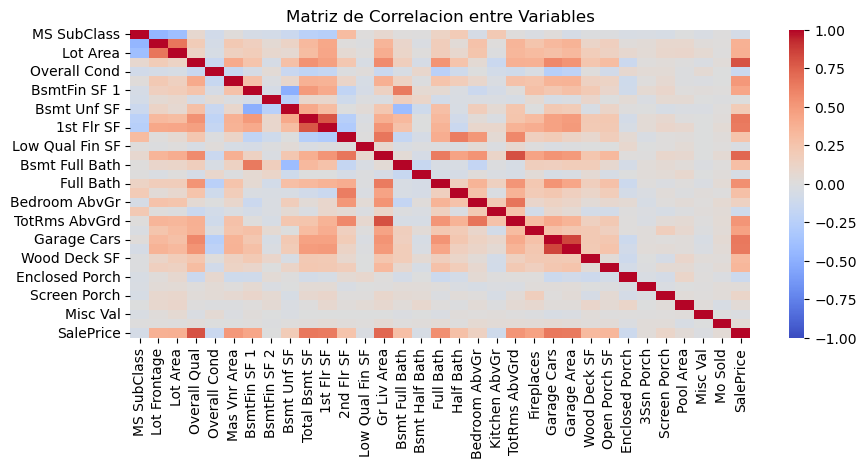

In [19]:
#Another way to discard unnecesary variables is identify variables highly correlated. Plotting the correlation matrix
#Cloud is a good way to identify them. Next the variables with a correlation upper than 0.8 will also drop
correlation_matrix = df_2.corr(numeric_only=True)

plt.figure(figsize=(10, 4))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, vmin=-1, vmax=1)
plt.title('Matriz de Correlacion entre Variables')
plt.show()

In [20]:
# The correlation metrix reveals nearly six higly correlated features. Let's identify those with a correlation greater than 0.8
mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool) # here creates the upper triangle of correlation values without the diagonal line
corr_feature = correlation_matrix.where(mask) # Here mask is applied to the correlation matrix to select the values
high_corr = [column for column in corr_feature.columns if any(corr_feature[column].abs() > 0.8) and column != 'SalePrice'] # Only the features with a correlation greater than 0.8 will be added

print("Variables with high correlation: ", high_corr)

Variables with high correlation:  ['TotRms AbvGrd', 'Garage Area']


In [21]:
# Elimination of features with high colinearity
df_3 = df_2.drop(columns=high_corr)
df_3.shape

(2765, 61)

In [22]:
#Identification of the variable types in the dataset
var_types = df_description['Type Variable'].unique().tolist()
var_types

['Discrete', 'Nominal', 'Continuous', 'Ordinal']

In [23]:
# Clasification of variables in the latest dataframe
def variables_classification(descriptive_data, working_data, types):
    clasified_var = {}
    for i in types:
        cond = set(descriptive_data[descriptive_data['Type Variable'] == i]['Variable'])
        var_list = [x for x in working_data.columns if x in cond]
        clasified_var[i] = var_list
    return clasified_var

var_clasified = variables_classification(df_description, df_3.drop(columns=['SalePrice']), var_types)

In [24]:
# The Overall Qual and Overall Cond must be deleted, because these variables are already transformed 
elements_to_remove = ['Overall Qual', 'Overall Cond']
var_clasified['Ordinal'] = [x for x in var_clasified['Ordinal'] if x not in elements_to_remove]

In [25]:
# Craeting the list of ordinal values by category. This to make the preprocessing of the ordinal features
def parse_ordinal_features(text):
    lines = text.strip().split('\n')
    
    ordinal_features = {} 
    
    current_variable = None
    current_type = None
    current_values = []
    
    for line in lines:
        line = line.strip()
        # Cheking if the current line contains '(', ')' and ':' to identify the type of variable
        if '(' in line and ')' in line and ':' in line:
            if current_variable and current_values and current_type and current_type.lower() == 'ordinal':
                ordinal_features[current_variable] = current_values.copy()
            
            parts = line.split('(')
            var_name = parts[0].strip()
            type_part = parts[1].split(')')[0].strip()
            
            current_variable = var_name
            current_type = type_part
            current_values = []
        # if '(', ')' and ':' aren't in the line and the current type is 'ordinal' the categories are the next values in the lines
        elif (current_variable and current_type and current_type.lower() == 'ordinal' 
                and line and not line.startswith(' ') and len(line.split()) >= 2):
            
            code = line.split()[0]
            # Previous to add the code let's check if those aren't in this list of words ['lot', 'type', 'general', 'size']
            if not any(word in code.lower() for word in ['lot', 'type', 'general', 'size']):
                current_values.append(code)
                
    # The last descriptive text of variable and types must be added to the dict of ordinal categories
    if current_variable and current_values and current_type and current_type.lower() == 'ordinal':
        ordinal_features[current_variable] = current_values.copy()
    
    return ordinal_features

categories_ordinal_variables = parse_ordinal_features(content)
ordinal_order = [categories_ordinal_variables[x] for x in var_clasified['Ordinal']] #Selection of features only on the latest clasified dataframe

ordinal_order = [x + ['NA'] if 'NA' not in x else x for x in ordinal_order] # Adding 'NA' to complete the null values in the categiry to avoid errors
ordinal_order

[['Reg', 'IR1', 'IR2', 'IR3', 'NA'],
 ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
 ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
 ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
 ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
 ['Gd', 'Av', 'Mn', 'No', 'NA'],
 ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
 ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
 ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
 ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix', 'NA'],
 ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
 ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal', 'NA'],
 ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
 ['Fin', 'RFn', 'Unf', 'NA'],
 ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
 ['Y', 'P', 'N', 'NA']]

In [26]:
cols_numeric = var_clasified['Continuous'] 
df_3[cols_numeric] = df_3[cols_numeric].fillna(df_3[cols_numeric].median())
df_3[var_clasified['Discrete']] = df_3[var_clasified['Discrete']].fillna(0)
cols_ordinal = var_clasified['Ordinal']
df_3[cols_ordinal] = df_3[cols_ordinal].fillna('NA')

#### <font color=#A0A0A0> **🤖 Modeling and Machine learning**</font>

In [27]:
preprocessor = ColumnTransformer(transformers=[
    ('cont', StandardScaler(), var_clasified['Continuous']),
    ('dic', 'passthrough', var_clasified['Discrete']),
    ('nom', OneHotEncoder(handle_unknown='ignore', drop='first'), var_clasified['Nominal']),
    ('ord', OrdinalEncoder(categories=ordinal_order, 
                        handle_unknown='use_encoded_value', unknown_value=-1), var_clasified['Ordinal'])
])

In [28]:
model  =Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(cv=5))
])

In [29]:
X = df_3.drop(columns=['SalePrice'])
y = df_3['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cont', StandardScaler(),
                                                  ['Lot Frontage', 'Lot Area',
                                                   'Mas Vnr Area',
                                                   'BsmtFin SF 1',
                                                   'BsmtFin SF 2',
                                                   'Bsmt Unf SF',
                                                   'Total Bsmt SF',
                                                   '1st Flr SF', '2nd Flr SF',
                                                   'Low Qual Fin SF',
                                                   'Gr Liv Area',
                                                   'Wood Deck SF',
                                                   'Open Porch SF',
                                                   'Enclosed Porch',
                                                   '3Ssn Porch', 'Screen Porch',
                                                   'Pool Area', 'Misc Val']),
                                                 ('dic', 'passthrough',
                                                  ['Bsmt Ful...
                                                                              'NA'],
                                                                             ['Ex',
                                                                              'Gd',
                                                                              'TA',
                                                                              'Fa',
                                                                              'Po',
                                                                              'NA'],
                                                                             ['Y',
                                                                              'P',
                                                                              'N',
                                                                              'NA']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Lot Shape', 'Exter Qual',
                                                   'Exter Cond', 'Bsmt Qual',
                                                   'Bsmt Cond', 'Bsmt Exposure',
                                                   'BsmtFin Type 1',
                                                   'BsmtFin Type 2',
                                                   'Heating QC', 'Electrical',
                                                   'Kitchen Qual', 'Functional',
                                                   'Fireplace Qu',
                                                   'Garage Finish',
                                                   'Garage Qual',
                                                   'Paved Drive'])])),
                ('regressor', LassoCV(cv=5))])

In [30]:
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
lasso_coef = model.named_steps['regressor'].coef_
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_coef
})
coef_df = coef_df[coef_df['Coefficient'].abs() > 1e-5]
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

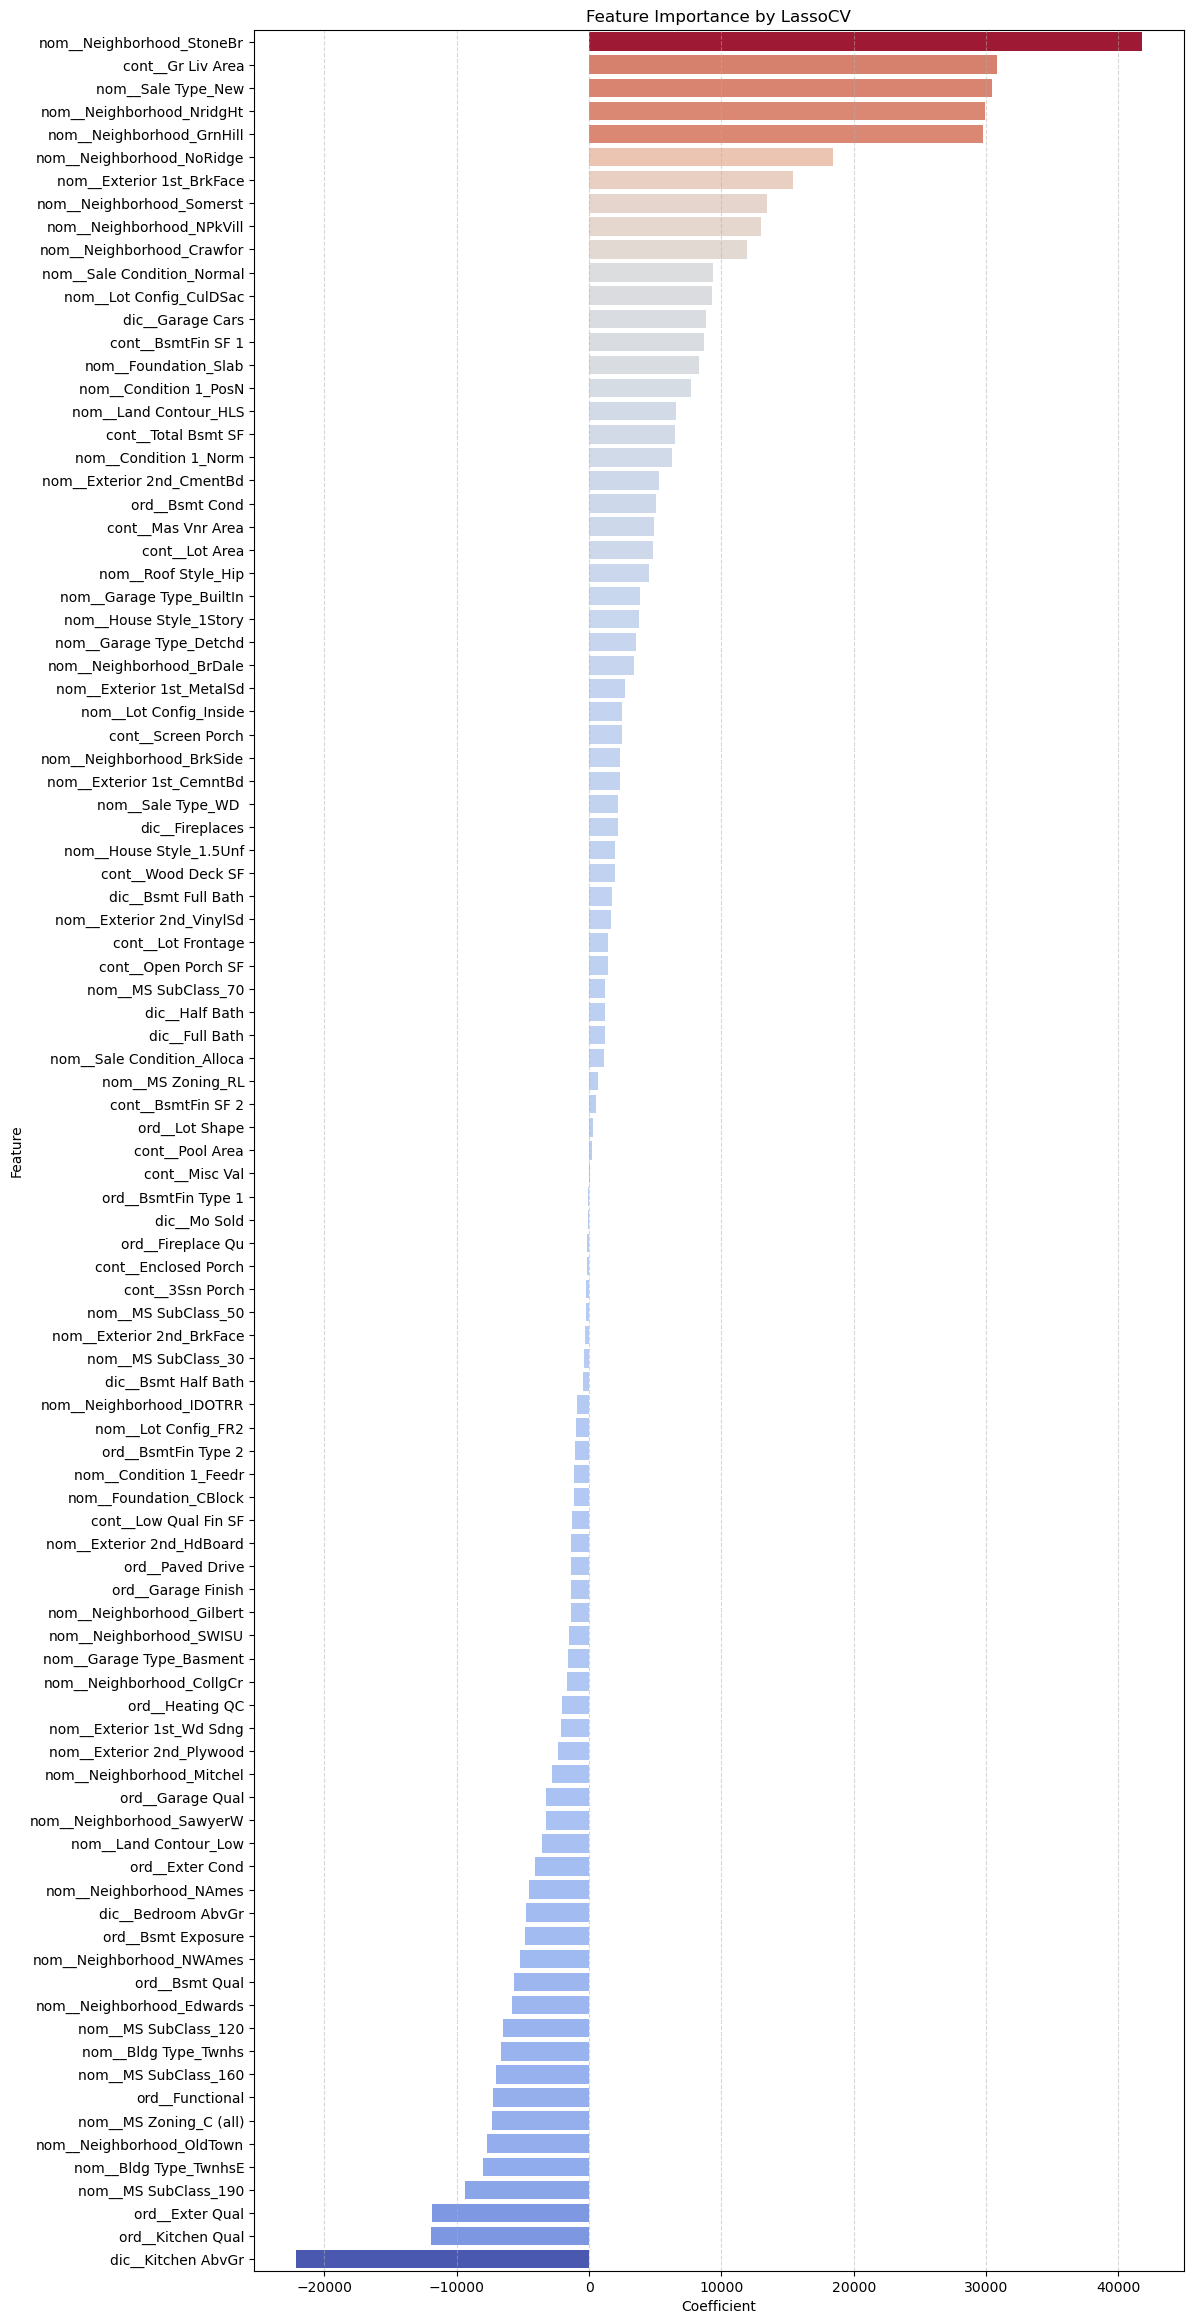

In [31]:
n_features = coef_df.shape[0]
height = max(6, 0.3*n_features)

plt.figure(figsize=(12, height))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, 
            palette='coolwarm', hue='Coefficient', dodge=False)

plt.title('Feature Importance by LassoCV')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend([],[], frameon=False)
plt.show()

The LassoCV model shows a clear importance of the neighborhood feature in the predictions of the model, this indicates a clear linear relationship beetween the neighborhood and the SalePrice. 
With less importance there's characteristics of the house like the living area, porch area, pool area and others. Later we will verify with other models if the most important variables change.

In [32]:
models = {
    'LinearRegression': LinearRegression(),
    'LassoCV': LassoCV(cv=5),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

results = []

for name, model_instance in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model_instance)
    ])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        scores = cross_val_score(pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
    results.append({
        'Model': name, 
        'RMSE Mean': -np.mean(scores),
        'RMSE Std': np.std(scores)
    })
    
results_df = pd.DataFrame(results).sort_values(by='RMSE Mean')
print(results_df)

              Model     RMSE Mean      RMSE Std
1           LassoCV  2.508021e+04  1.453144e+03
2      RandomForest  2.602348e+04  2.169383e+03
3           XGBoost  2.604647e+04  1.438869e+03
0  LinearRegression  1.665776e+14  1.839946e+14


The results of the model testing shows that LassoCV and LinearRegression has the lower RMSE Mean, but LassoCV with a bit higher std but its the best model representing the data. The feature selection could could make this model the best one.

In [33]:
# Tuning de hiperparámetros
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
}

grid_search = GridSearchCV(
    Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ]),
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X, y)
print(f"Best RMSE: {-grid_search.best_score_:.2f}")
print("Best params:", grid_search.best_params_)

Best RMSE: 25981.58
Best params: {'regressor__max_depth': 20, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}


In [34]:
pipe_xgboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators =100, random_state=42, verbosity=0))
])

param_grid = {
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__n_estimators': [100, 150, 200],
    'regressor__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=pipe_xgboost, 
                        param_grid=param_grid,
                        cv=5, 
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1,
                        verbose=1)

grid_search.fit(X, y)
best_index = grid_search.best_index_
std_rmse = grid_search.cv_results_['std_test_score'][best_index]

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score (RMSE):", -grid_search.best_score_)
print("Mejor score (std_RMSE):", std_rmse)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores parámetros: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
Mejor score (RMSE): 23181.332023739844
Mejor score (std_RMSE): 1101.9997883974515


The GridSearchCV for XGBoost get a better mean for the RMSE and std score than the other models, improving the Lasso and RandomForestRegressor, this is for it's capabiilities of capturing no linear relationships and selectiong and automated selection of relevant variables.

In [56]:
# Now that the best model has been identified the next step is to train the model and test it with the test data
# and check the model with the RMSE and the correlation 
best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'RMSE test: {rmse:.2f}')
print(f'MAE test: {mae:.2f}')
print(f'R2 test: {r2:.2f}')

RMSE test: 24549.04
MAE test: 16000.57
R2 test: 0.91


C:\Users\PERSONAL\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [9, 13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Even with the test data the RMSE keeps being the best model.  
It'll gonna be good plot a graph of the real values against the predicted values

#### <font color=#A0A0A0> **🤖 Results and Evaluation**</font>

In [53]:
ohe = best_model.named_steps['preprocessor'].named_transformers_['nom']
ohe_features = ohe.get_feature_names_out(var_clasified['Nominal'])
ord_features = var_clasified['Ordinal']

all_features = np.concatenate([var_clasified['Continuous'], var_clasified['Discrete'], ohe_features, ord_features])

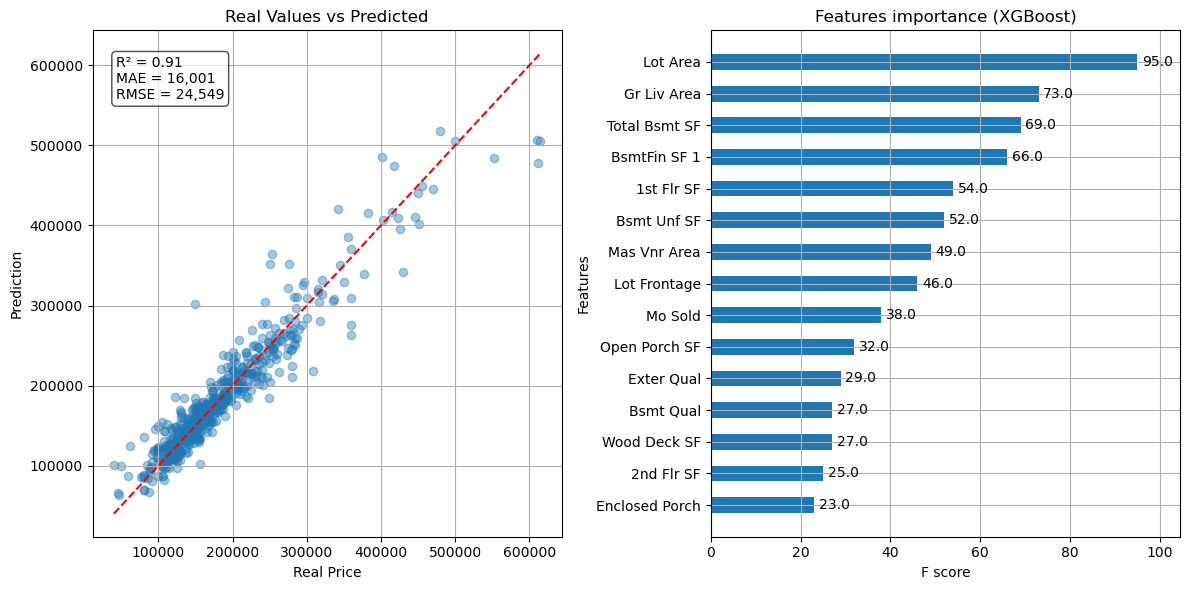

In [71]:
# Theres's a clear correlation between the real price and the predicted values.
# Let's plot of the most important features and a scatter of predicted vs real values

xgb_model = best_model.named_steps['regressor']
xgb_model.get_booster().feature_names = list(all_features)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(y_test, y_pred, alpha=0.4)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_xlabel('Real Price')
axes[0].set_ylabel('Prediction')
axes[0].set_title('Real Values vs Predicted')
axes[0].grid(True)
metrics_text = f'R² = {r2:.2f}\nMAE = {mae:,.0f}\nRMSE = {rmse:,.0f}'
axes[0].text(0.05, 0.95, metrics_text, transform=axes[0].transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plot_importance(xgb_model, ax=axes[1], max_num_features=15, height=0.5)
axes[1].set_title("Features importance (XGBoost)")

plt.tight_layout()
plt.savefig('../assests/model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

The distribution of the data is uniform around the regression line, which indicates that the model makes unbias prdictions. Therefore it meets the homoscedasticity condition.

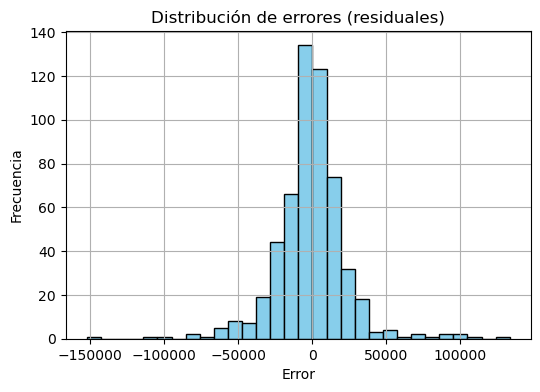

In [37]:
# This is the distribution of the residuals with a clear mean at 0 which is good for our model.
# This tell us that the mos of the predictions are near to the real value.
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribución de errores (residuales)")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

All the features are related with important stuff of the house, like areas of the house, porch, basement etc. But there's one variable that is out of this patter f26 - Mo Sold (Month Sold)

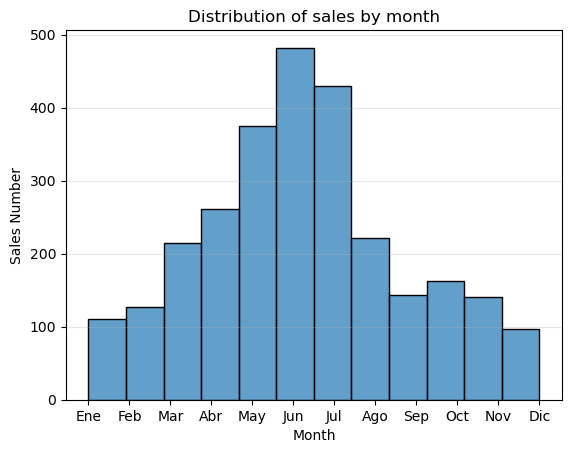

In [ ]:
# Let's see the distribution of sales by month
sns.histplot(data=df_3, x=df_3['Mo Sold'], bins=12, edgecolor='black', alpha=0.7)
plt.xlabel('Month')
plt.ylabel('Sales Number')
plt.title('Distribution of sales by month')
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                        'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.grid(axis='y', alpha=0.3)
plt.show()

The summer months seems to have the most number of sales. This may be because this is the perfect climate for moving and to check very well the conditions of the house. Let see how the month affects the price of the houses

C:\Users\PERSONAL\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [9, 13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
PermutationExplainer explainer: 554it [00:34, 13.67it/s]                         


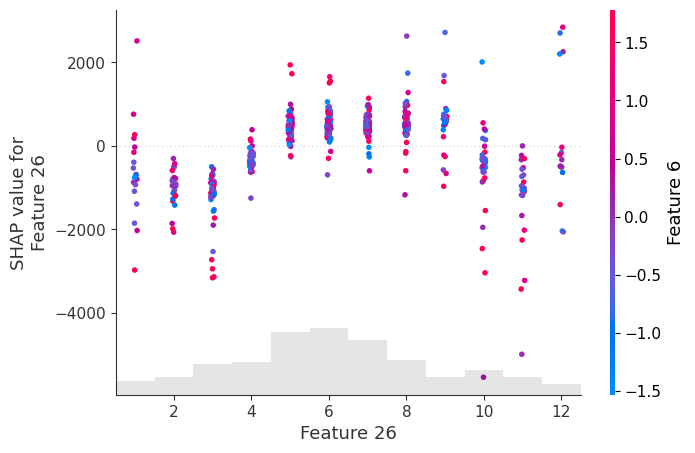

In [ ]:
# shap is a good library to check how the prediction change according to the value of a variable
# So let's transform the test data with the preprocessor. to make a prediction of this data and display
# The influence of each month on the SalePrice.
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

f26_index = np.where(all_features == 'Mo Sold')[0][0]
regressor = best_model.named_steps['regressor']
explainer = shap.Explainer(regressor.predict, X_test_transformed)
shap_values = explainer(X_test_transformed)
shap.plots.scatter(shap_values[:, f26_index], color=shap_values)

As was predictable a major demand of house in summer makes the prices higher on average 800 more expensive and in winter months the prices go down by around 1200 which makes sense, low demand makes the prices lower.

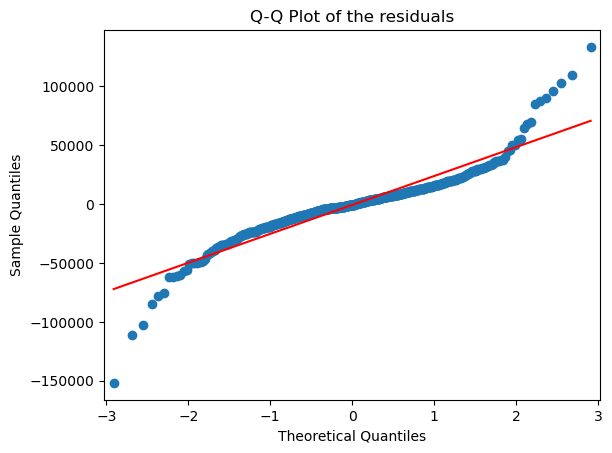

In [ ]:
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of the residuals')
plt.show()

the Q.Q plot shows if the errors of the model keeps a normal distribution. 
This plot after 2 quantile has a deviation with some errors, which could be outliers. In linear model is important that the models keep a normal distribution, but in this case for the XGBoost model is not a problem, because this model can deal with no lineal relationships.

#### <font color=#A0A0A0> **🧐✅ Conclusions**</font>

In this project, we addressed the challenge of predicting residential housing prices using supervised machine learning techniques. Leveraging a large and heterogeneous dataset, we performed rigorous data cleaning, robust preprocessing, and informed feature selection to build accurate and generalizable predictive models.

Among the models tested, XGBoost delivered the best performance, achieving the lowest RMSE. The model also attained a high R² value (≈ 0.91), indicating that approximately 91% of the variability in housing prices can be explained by the independent variables. Therefore, this model serves as a strong approximation of real housing prices and could be a valuable reference point for both buyers and sellers.

Initially, the dataset contained 81 features. After removing features with excessive missing values and low variance since they introduce noise 61 variables remained for model training. All variables were preprocessed: continuous features were scaled, and categorical features were encoded using OneHotEncoder and OrdinalEncoder, depending on their nature.

From an interpretability standpoint, features related to surface area—such as living area, basement size, and lot frontage—as well as the overall quality of the property proved to be the most influential in price prediction. Interestingly, one temporal feature, “Mo Sold” (month of sale), also showed significant importance. The model indicates that prices tend to increase during the summer months, likely due to higher demand. This could be attributed to more favorable weather conditions for inspecting homes and the convenience of moving during school vacations.

To further improve the model, additional features could be incorporated, such as proximity to points of interest (supermarkets, gas stations, downtown, or public transportation), interest rates, and geographic location coordinates, which would provide spatial and macroeconomic context to enhance prediction accuracy.
